<a href="https://colab.research.google.com/github/erenyildiz/MLhomework/blob/master/Week4TransferLearningOnHealthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation of Libraries

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell

from google.colab import drive

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, \
  GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
  preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils.class_weight import compute_class_weight

from itertools import product
from functools import partial

##Mount Google Drive

In [2]:
#mounting drive to output the data on google drive
#original data is https://data.mendeley.com/datasets/rscbjbr9sj/2/files/41d542e7-7f91-47f6-9ff2-dd8e5a5a7861/ChestXRay2017.zip?dl=1
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/ChestXRay2017/chest_xray"

Mounted at /content/drive
/content/drive/My Drive/ChestXRay2017/chest_xray


##Separately Save the Folders

In [0]:
train_dir = 'train'
validation_dir = 'val'
test_dir = 'test'

##Check a random image

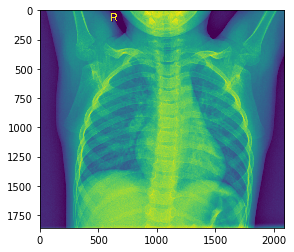

In [4]:
img = mpimg.imread(train_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
K.clear_session()

NUM_CLASSES = 2




##Start working on InceptionV3

In [0]:
def create_model(input_shape):
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  return model

In [7]:
model = create_model((150, 150, 3))

training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(2048, 512) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(512, 256) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 128) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_3/kernel:0' shape=(128, 2) dtype=float32>,
 <tf.Variable 'dense_3/bias:0' shape=(2,) dtype=float32>]

##Optimize

In [0]:
# with strategy.scope():
optimizer = Adam(lr=0.0001)
# optimizer = RMSprop()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [11]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = 'categorical'


def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])


train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5245 images belonging to 2 classes.
Found 9 images belonging to 2 classes.
Found 626 images belonging to 2 classes.


In [12]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)


[1.93542435 0.67416452]


In [15]:
# with strategy.scope():
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=5,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=22)

MODEL_FILE = 'pneumonia_v0.0.1.hd5'
model.save(MODEL_FILE)

Epoch 1/5
33/33 [==============================] - 369s 11s/step - loss: 0.5312 - acc: 0.7628 - val_loss: 0.6981 - val_acc: 0.5556
Epoch 2/5
33/33 [==============================] - 341s 10s/step - loss: 0.3786 - acc: 0.8459 - val_loss: 0.2006 - val_acc: 0.8889
Epoch 3/5
33/33 [==============================] - 337s 10s/step - loss: 0.3063 - acc: 0.8810 - val_loss: 0.4043 - val_acc: 0.8889
Epoch 4/5
33/33 [==============================] - 342s 10s/step - loss: 0.2903 - acc: 0.8894 - val_loss: 0.5184 - val_acc: 0.7778
Epoch 5/5
33/33 [==============================] - 342s 10s/step - loss: 0.2786 - acc: 0.8957 - val_loss: 0.1534 - val_acc: 0.8889


In [0]:
%mkdir -p '/content/drive/My Drive/ML_Course_Siraj/Week_04'
!mv {MODEL_FILE} '/content/drive/My Drive/ML_Course_Siraj/Week_04'

In [17]:
MODEL_FILE = f'/content/drive/My Drive/ML_Course_Siraj/Week_04/{MODEL_FILE}'
model = tf.keras.models.load_model(MODEL_FILE)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 233s 233s/step - loss: 1.1459 - acc: 0.7157
Loss     : 1.15  
Accuracy : 71.57%


In [19]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

1/1 [==============================] - 42s 42s/step


In [20]:
import random

num_of_batch = len(test_generator)
batch_no = random.randint(0, num_of_batch - 1)

y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 626
-----------------------------------
Accuracy                : 71.57%
-----------------------------------


In [36]:
result  = model.evaluate_generator(test_generator,steps=len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 1.1459301710128784
Accuracy: 0.71565497


In [34]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

##Predictions

In [37]:
#Generate all predictions
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

KeyboardInterrupt: ignored

##Results

In [33]:
predicted_class_indices = np.argmax(predict, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})

InteractiveShell.ast_node_interactivity = "all"

results

NameError: ignored

##Confusion Matrix

In [0]:
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

##Image Examples of Predictions

In [0]:
def plot_val_xrays(width=width//2, height=height//2,
                   rows=10, cols=3,
                   size_w=4, size_h=3.5):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  label_CM = {
    0: 'red',  # Incorrect diagnosis
    1: 'green' # Correct diagnosis
  }

  for idx in range(0, rows*cols):
    i = random.randint(0, len(images_test))
    pred = np.round(vl_score[i][1])
    score = 1 if test_generator.classes[i] == pred else 0
        
    diagnosis_type = 'Pneumonia' if test_generator.classes[i] == 1 else 'Normal'
    diagnosis_conf = vl_score[i][1] * 100.0
    diagnosis = 'Diagnosis: {}\n{:.1f}% Confidence'.format(diagnosis_type,
                                                           diagnosis_conf)

    im = get_resized_image(images_test[i], width, height)[:, :, 0]
    ax[idx//cols,idx%cols].imshow(im, cmap='bone')
    ax[idx//cols,idx%cols].axis('off')
    ax[idx//cols,idx%cols].set_title(diagnosis, color=label_CM[score])
  plt.show()

plot_val_xrays()